# XGB Fraud with Magic scores LB 0.96
This model is part of the 1st place solution to Kaggle's "IEEE-CIS Fraud Detection" competition. When this model is ensembled together with [Konstantin's][1] CatBoost and LGBM models, the result achieves public LB 0.9677 and private LB 0.9459 taking first place [here][2]
  
In this kernel, we build two XGB models. The first model does not use the magic features and achieves LB 0.95. The second model uses the magic features and achieves LB 0.96. In the appendix, we demonstrate how to increase LB further with post processing.

[1]: https://www.kaggle.com/kyakovlev
[2]: https://www.kaggle.com/c/ieee-fraud-detection/leaderboard

# How the Magic Works
The magic is two things. First we need a UID variable to identify clients (credit cards). Second, we need to create aggregated group features. Then we remove UID. Suppose we had 10 transactions `A, B, C, D, E, F, G, H, I, J` as below.  
  
![image](http://playagricola.com/Kaggle/table.jpg)  
  
If we only use FeatureX, we can classify 70% of the transactions correctly.   
  
![image](http://playagricola.com/Kaggle/tran.jpg)  
  
Now suppose that we have a UID which defines groups and we make an aggregated feature by taking the average of FeatureX within each group. We can now classify 100% of the transactions correctly. Note that we never use the feature UID in our decision tree.  
  
![image](http://playagricola.com/Kaggle/cred.jpg)

# Load Data
We will load all the data except 219 V columns that were determined redundant by correlation analysis [here][1]

[1]: https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id

In [1]:
BUILD95 = True
BUILD96 = True

import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]: 
    dtypes[c] = 'float32'
for c in str_type: dtypes[c] = 'category'

In [2]:
# LOAD TRAIN
X_train = pd.read_csv('../../input/ieee-cis-fraud-detection/train_transaction.csv',
                      index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv('../../input/ieee-cis-fraud-detection/train_identity.csv',
                       index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)
# LOAD TEST
X_test = pd.read_csv('../../input/ieee-cis-fraud-detection/test_transaction.csv',
                     index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv('../../input/ieee-cis-fraud-detection/test_identity.csv',
                      index_col='TransactionID', dtype=dtypes)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (506691, 213)


# Normalize D Columns
The D Columns are "time deltas" from some point in the past. We will transform the D Columns into their point in the past. This will stop the D columns from increasing with time. The formula is `D15n = Transaction_Day - D15` and `Transaction_Day = TransactionDT/(24*60*60)`. And then we will take the negative of this number.

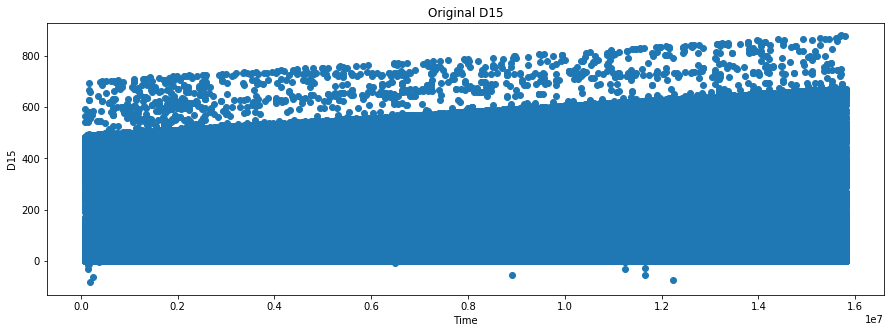

In [3]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

In [4]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 

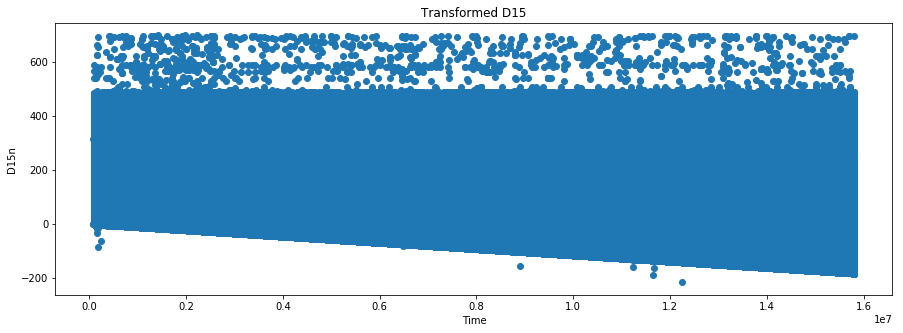

In [5]:
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

In [6]:
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (np.str(X_train[f].dtype)=='category') | (X_train[f].dtype=='object'): 
        df_comb = pd.concat([X_train[f], X_test[f]], axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max() > 32000: 
            print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt', 'TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

# Encoding Functions
Below are 5 encoding functions.

1. `encode_FE` does frequency encoding where it combines train and test first and then encodes. 
2. `encode_LE` is a label encoded for categorical features 
3. `encode_AG` makes aggregated features such as aggregated mean and std 
4. `encode_CB` combines two columns 
5. `encode_AG2` makes aggregated features where it counts how many unique values of one feature is within a group. 

For more explanation about feature engineering, see the discussion [here][1]

[1]: https://www.kaggle.com/c/ieee-fraud-detection/discussion/108575#latest-641841

In [8]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col, train=X_train, test=X_test, verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True) # pandas factorize 在處理 None 會轉為 -1
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column + '_' + col + '_' + agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: 
                    temp_df.loc[temp_df[main_column]==-1, main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                    columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1, inplace=True)
                    test_df[new_col_name].fillna(-1, inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1, col2,df1=X_train,df2=X_test):
    nm = col1 + '_' + col2
    df1[nm] = df1[col1].astype(str) + '_' + df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str) + '_' + df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

# Feature Engineering
We will now engineer features. All of these features where chosen because each increases local validation. The procedure for engineering features is as follows. First you think of an idea and create a new feature. Then you add it to your model and evaluate whether local validation AUC increases or decreases. If AUC increases keep the feature, otherwise discard the feature.

In [8]:
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)
# SUM NUMBER OF NANS FOR EACH ROW IN DATA
info = ['card1','card2','card3','card4','card5','card6','addr1','addr2','P_emaildomain','R_emaildomain']
X_train['missing'] = X_train[info].isna().sum(axis=1).astype('int8')
X_test['missing'] = X_test[info].isna().sum(axis=1).astype('int8')
print('missing', end='')

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , missing

# Feature Selection - Time Consistency
We added 29 new feature above. We have already removed 219 V Columns from correlation analysis done [here][1]. So we currently have 243 features now. We will now check each of our 243 for "time consistency". We will build 243 models. Each model will be trained on the first month of the training data and will only use one feature. We will then predict the last month of the training data. We want both training AUC and validation AUC to be above `AUC = 0.5`. It turns out that 19 features fail this test so we will remove them. Additionally we will remove 7 D columns that are mostly NAN. More techniques for feature selection are listed [here][2]

[1]: https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
[2]: https://www.kaggle.com/c/ieee-fraud-detection/discussion/111308

In [9]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [10]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 217 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

# Local Validation
For this competition, we used time based local validation. I evaluated features by training on the first 75% of the data and predicting the last 25% of the data. Konstantin had a slightly different local validaiton. He trained on the first 4 months, skipped a month, and predicted the last month. Our current XGB model with 217 features achieves AUC = 0.9363 on Chris' local validation and AUC = 0.9241 on Konstantin's local validation. Note that this is the same AUC that Konstantin's LGBM achieves without magic that he posted [here][1] and [here][2].

[1]: https://www.kaggle.com/kyakovlev/ieee-fe-for-local-test
[2]: https://www.kaggle.com/kyakovlev/ieee-lgbm-with-groupkfold-cv

In [11]:
# CHRIS - TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

# KONSTANTIN - TRAIN 4 SKIP 1 PREDICT 1 MONTH
#idxT = X_train.index[:417559]
#idxV = X_train.index[-89326:]

In [12]:
import xgboost as xgb
print("XGBoost version:", xgb.__version__)

if BUILD95:
    clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        # USE CPU
        #nthread=4,
        #tree_method='hist' 
        # USE GPU
        tree_method='gpu_hist' 
    )
    h = clf.fit(X_train.loc[idxT,cols], y_train[idxT], 
        eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
        verbose=50, early_stopping_rounds=100)

XGBoost version: 0.90
[0]	validation_0-auc:0.787465
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.876804
[100]	validation_0-auc:0.893032
[150]	validation_0-auc:0.906405
[200]	validation_0-auc:0.917195
[250]	validation_0-auc:0.924715
[300]	validation_0-auc:0.929576
[350]	validation_0-auc:0.932583
[400]	validation_0-auc:0.934352
[450]	validation_0-auc:0.935269
[500]	validation_0-auc:0.935772
[550]	validation_0-auc:0.935786
[600]	validation_0-auc:0.935778
[650]	validation_0-auc:0.935696
Stopping. Best iteration:
[565]	validation_0-auc:0.935881



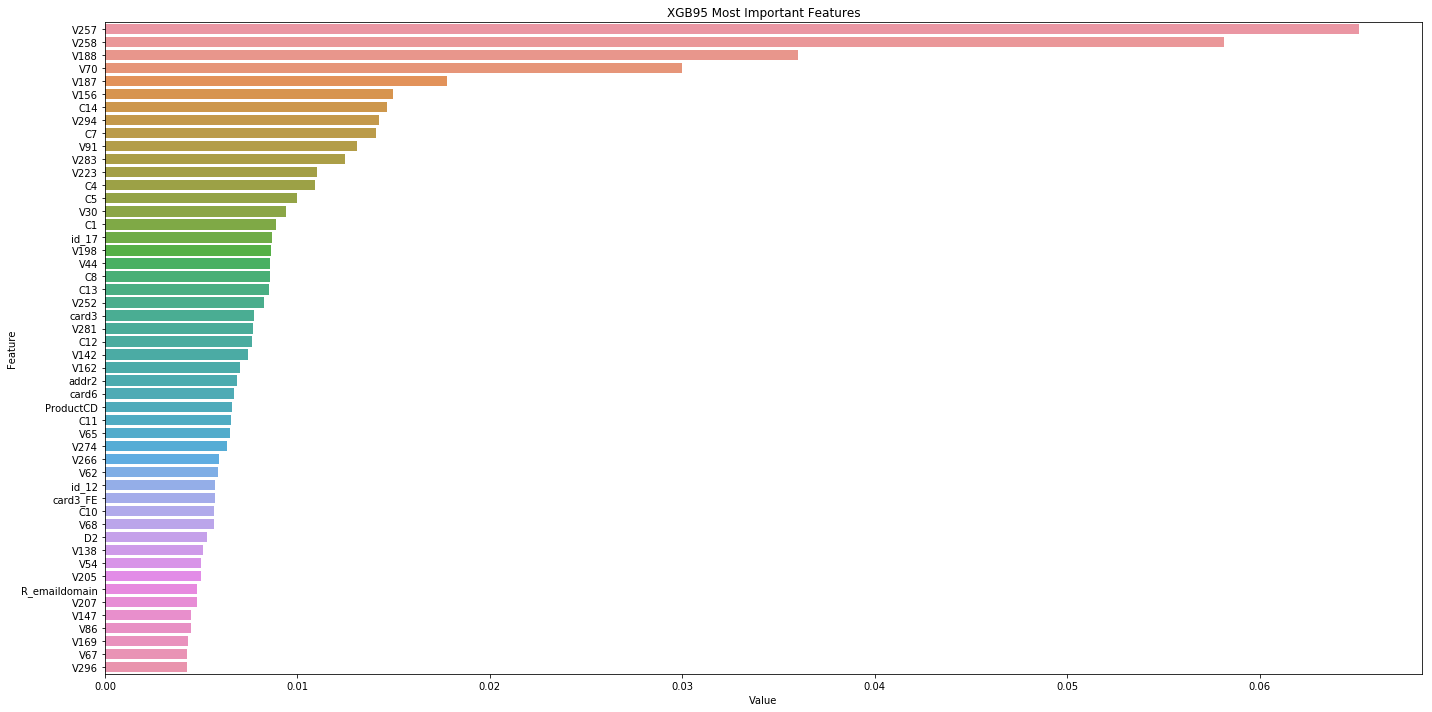

In [13]:
if BUILD95:
    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title('XGB95 Most Important Features')
    plt.tight_layout()
    plt.show()
    del clf, h; x=gc.collect()

# Predict test.csv
We will predict `test.csv` using GroupKFold with months as groups. The training data are the months December 2017, January 2018, February 2018, March 2018, April 2018, and May 2018. We refer to these months as 12, 13, 14, 15, 16, 17. Fold one in GroupKFold will train on months 13 thru 17 and predict month 12. Note that the only purpose of month 12 is to tell XGB when to `early_stop` we don't actual care about the backwards time predictions. The model trained on months 13 thru 17 will also predict `test.csv` which is forward in time.
  
Note that we use local validation to determine features but GroupKFold to predict `test.csv`. Many other prediction schemes were tried but GroupKFold performed best.

In [14]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 

In [15]:
if BUILD95:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold',i,'withholding month',month)
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE CPU
            #nthread=4,
            #tree_method='hist'
            # USE GPU
            tree_method='gpu_hist' 
        )        
        h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
                eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
                verbose=100, early_stopping_rounds=200)
    
        oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
        preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
        del h, clf
        x=gc.collect()
    print('#'*20)
    print ('XGB95 OOF CV=',roc_auc_score(y_train,oof))

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.757194
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.87273
[200]	validation_0-auc:0.893031
[300]	validation_0-auc:0.902664
[400]	validation_0-auc:0.906759
[500]	validation_0-auc:0.908717
[600]	validation_0-auc:0.909639
[700]	validation_0-auc:0.909689
[800]	validation_0-auc:0.90932
Stopping. Best iteration:
[654]	validation_0-auc:0.910163

Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
[0]	validation_0-auc:0.832247
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.906954
[200]	validation_0-auc:0.930137
[300]	validation_0-auc:0.941102
[400]	validation_0-auc:0.945543
[500]	validation_0-auc:0.946704
[600]	validation_0-auc:0.947051
[700]	validation_0-auc:0.947245
[800]	validation_0-auc:0.947047
[900]	validation_0-auc:0.946743
Stopping. Best iteration:
[714]	validation_0-auc:0.9473

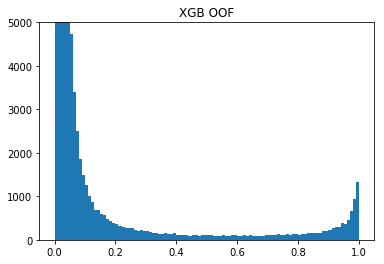

In [16]:
if BUILD95:
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB OOF')
    plt.show()

    X_train['oof'] = oof
    X_train.reset_index(inplace=True)
    X_train[['TransactionID','oof']].to_csv('oof_xgb_95.csv')
    X_train.set_index('TransactionID',drop=True,inplace=True)

# Kaggle Submission File XGB_95

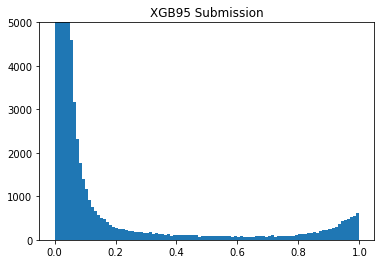

In [17]:
if BUILD95:
    sample_submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
    sample_submission.isFraud = preds
    sample_submission.to_csv('sub_xgb_95.csv',index=False)

    plt.hist(sample_submission.isFraud,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB95 Submission')
    plt.show()

![image](http://www.playagricola.com/Kaggle/9510.png)

# The Magic Feature - UID
We will now create and use the MAGIC FEATURES. First we create a UID which will help our model find clients (credit cards). This UID isn't perfect. Many UID values contain 2 or more clients inside. However our model will detect this and by adding more splits with its trees, it will split these UIDs and find the single clients (credit cards).

In [18]:
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)

# Group Aggregation Features
For our model to use the new UID, we need to make lots of aggregated group features. We will add 47 new features! The pictures in the introduction to this notebook explain why this works. Note that after aggregation, we remove UID from our model. We don't use UID directly.

In [19]:
# FREQUENCY ENCODE UID
encode_FE(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],fillna=True,usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'],['uid'],['std'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE 
encode_AG2(['C13','V314'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREATE 
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)
# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

uid_FE , 'TransactionAmt_uid_mean' , 'TransactionAmt_uid_std' , 'D4_uid_mean' , 'D4_uid_std' , 'D9_uid_mean' , 'D9_uid_std' , 'D10_uid_mean' , 'D10_uid_std' , 'D15_uid_mean' , 'D15_uid_std' , 'C1_uid_mean' , 'C2_uid_mean' , 'C4_uid_mean' , 'C5_uid_mean' , 'C6_uid_mean' , 'C7_uid_mean' , 'C8_uid_mean' , 'C9_uid_mean' , 'C10_uid_mean' , 'C11_uid_mean' , 'C12_uid_mean' , 'C13_uid_mean' , 'C14_uid_mean' , 'M1_uid_mean' , 'M2_uid_mean' , 'M3_uid_mean' , 'M4_uid_mean' , 'M5_uid_mean' , 'M6_uid_mean' , 'M7_uid_mean' , 'M8_uid_mean' , 'M9_uid_mean' , uid_P_emaildomain_ct, uid_dist1_ct, uid_DT_M_ct, uid_id_02_ct, uid_cents_ct, 'C14_uid_std' , uid_C13_ct, uid_V314_ct, uid_V127_ct, uid_V136_ct, uid_V309_ct, uid_V307_ct, uid_V320_ct, outsider15


In [20]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
for c in ['oof','DT_M','day','uid']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)

In [21]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 264 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

# Local Validation
We will now perform local validation with the new magic features included. Chris' local validation now achieves AUC = 0.9472 and Konstantin's local validation achieves AUC = 0.9343. Note that without the magic features we achieved AUC = 0.9363 and AUC = 0.9241. We gained AUC 0.01 in both validations therefore our LB should increase from 0.95 to 0.96. Konstantin's LGBM with magic scores Konstantin local validation AUC = 0.9377 [here][1]

[1]: https://www.kaggle.com/kyakovlev/ieee-basic-fe-part-1

In [22]:
# CHRIS - TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

# KONSTANTIN - TRAIN 4 SKIP 1 PREDICT 1 MONTH
#idxT = X_train.index[:417559]
#idxV = X_train.index[-89326:]

In [23]:
if BUILD96:
    clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        #nthread=4,
        #tree_method='hist' 
        tree_method='gpu_hist' 
    )
    h = clf.fit(X_train.loc[idxT,cols], y_train[idxT], 
        eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
        verbose=50, early_stopping_rounds=100)

[0]	validation_0-auc:0.819718
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.890978
[100]	validation_0-auc:0.906742
[150]	validation_0-auc:0.920516
[200]	validation_0-auc:0.932132
[250]	validation_0-auc:0.938843
[300]	validation_0-auc:0.943239
[350]	validation_0-auc:0.94576
[400]	validation_0-auc:0.94708
[450]	validation_0-auc:0.94773
[500]	validation_0-auc:0.947827
[550]	validation_0-auc:0.947985
[600]	validation_0-auc:0.947904
[650]	validation_0-auc:0.947627
Stopping. Best iteration:
[555]	validation_0-auc:0.948043



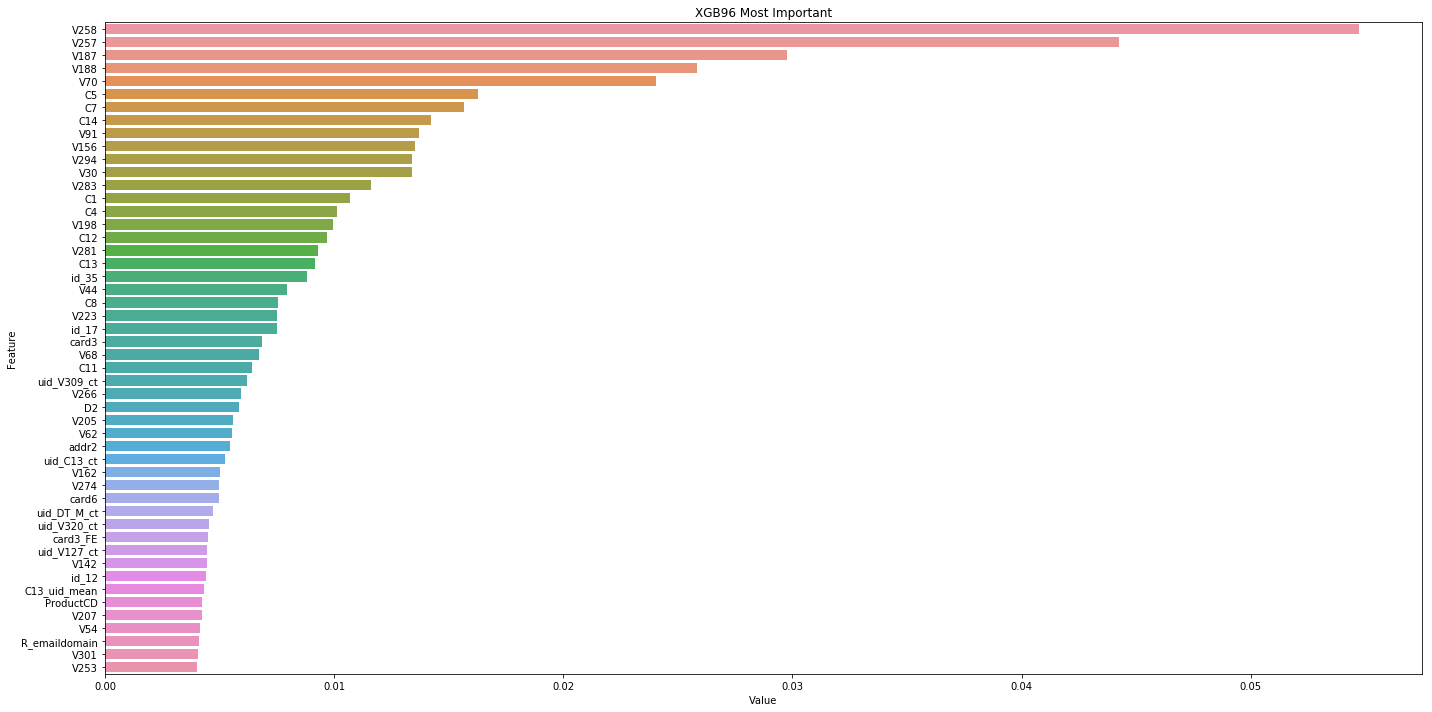

In [24]:
if BUILD96:
    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title('XGB96 Most Important')
    plt.tight_layout()
    plt.show()
        
    del clf, h; x=gc.collect()

# Predict test.csv

In [25]:
if BUILD96:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold',i,'withholding month',month)
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE CPU
            #nthread=4,
            #tree_method='hist'
            # USE GPU
            tree_method='gpu_hist' 
        )        
        h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
                eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
                verbose=100, early_stopping_rounds=200)
    
        oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
        preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
        del h, clf
        x=gc.collect()
    print('#'*20)
    print ('XGB96 OOF CV=',roc_auc_score(y_train,oof))

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.796647
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.894249
[200]	validation_0-auc:0.914037
[300]	validation_0-auc:0.9206
[400]	validation_0-auc:0.92219
[500]	validation_0-auc:0.922975
[600]	validation_0-auc:0.923951
[700]	validation_0-auc:0.924347
[800]	validation_0-auc:0.925202
[900]	validation_0-auc:0.925603
[1000]	validation_0-auc:0.925629
[1100]	validation_0-auc:0.926196
[1200]	validation_0-auc:0.926393
[1300]	validation_0-auc:0.927015
[1400]	validation_0-auc:0.926999
[1500]	validation_0-auc:0.927477
[1600]	validation_0-auc:0.92755
[1700]	validation_0-auc:0.927648
[1800]	validation_0-auc:0.927801
[1900]	validation_0-auc:0.928325
[2000]	validation_0-auc:0.928693
[2100]	validation_0-auc:0.928537
Stopping. Best iteration:
[1965]	validation_0-auc:0.928727

Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
[0]	validat

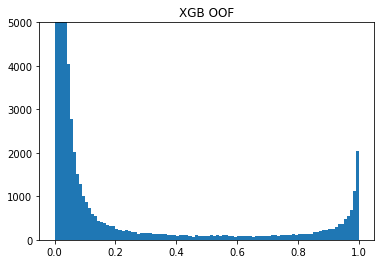

In [26]:
if BUILD96:
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB OOF')
    plt.show()

    X_train['oof'] = oof
    X_train.reset_index(inplace=True)
    X_train[['TransactionID','oof']].to_csv('oof_xgb_96.csv')
    X_train.set_index('TransactionID',drop=True,inplace=True)

# Kaggle Submission File XGB_96

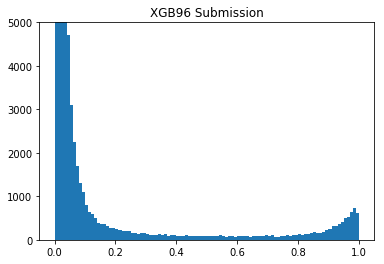

In [27]:
if BUILD96:
    sample_submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv')
    sample_submission.isFraud = preds
    sample_submission.to_csv('sub_xgb_96.csv',index=False)

    plt.hist(sample_submission.isFraud,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB96 Submission')
    plt.show()

![image](http://playagricola.com/Kaggle/9600.png)

# Post Process File XGB_96_PP
Our final submission is an ensemble of XGB, CatBoost, and LGBM. Then we post process the ensemble. We will not load the CatBoost and LGBM here, but we will show you the post process. Konstantin wrote a script [here][1] that finds precise UIDs (more precise than `card1_addr1_D1n`). We believe each to be an individual client (credit card). Analysis shows us that all transactions from a single client (one of Konstantin's UIDs) are either all `isFraud=0` or all `isFraud=1`. In other words, all their predictions are the same. Therefore our post process is to replace all predictions from one client with their average prediction including the `isFraud` values from the train dataset. We have two slightly different versions so we apply them sequentially.

Applying post process on our XGB model increases its Public LB to 0.9618 from LB 0.9602. And increases its Private LB to 0.9341 from LB 0.9324. This is an improvement of LB 0.0016 !!

[1]: https://www.kaggle.com/kyakovlev/ieee-uid-detection-v6

In [28]:
X_test['isFraud'] = sample_submission.isFraud.values
X_train['isFraud'] = y_train.values
comb = pd.concat([X_train[['isFraud']],X_test[['isFraud']]],axis=0)

uids = pd.read_csv('/kaggle/input/ieee-submissions-and-uids/uids_v4_no_multiuid_cleaning..csv',usecols=['TransactionID','uid']).rename({'uid':'uid2'},axis=1)
comb = comb.merge(uids,on='TransactionID',how='left')
mp = comb.groupby('uid2').isFraud.agg(['mean'])
comb.loc[comb.uid2>0,'isFraud'] = comb.loc[comb.uid2>0].uid2.map(mp['mean'])

uids = pd.read_csv('/kaggle/input/ieee-submissions-and-uids/uids_v1_no_multiuid_cleaning.csv',usecols=['TransactionID','uid']).rename({'uid':'uid3'},axis=1)
comb = comb.merge(uids,on='TransactionID',how='left')
mp = comb.groupby('uid3').isFraud.agg(['mean'])
comb.loc[comb.uid3>0,'isFraud'] = comb.loc[comb.uid3>0].uid3.map(mp['mean'])

sample_submission.isFraud = comb.iloc[len(X_train):].isFraud.values
sample_submission.to_csv('sub_xgb_96_PP.csv',index=False)

![image](http://playagricola.com/Kaggle/xgbpp.png)